<a href="https://colab.research.google.com/github/bhargavjay/Centralized-repository-shipping_calculations/blob/main/ML%20Code%20Gene%20Expression%20cancer%20RNA%20Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)
from xgboost import XGBRegressor
from scipy.stats import ttest_ind

import joblib

In [20]:
# PART 1: LOAD DATA
X = pd.read_csv('/content/data.csv', index_col=0)
y = pd.read_csv('/content/labels.csv', index_col=0)['Class']
y = y[X.index]  # Align indexes

In [36]:
# PART 2: DATA INFO AND SUMMARY
print("DATA INFO")
X.info()
print("\n SUMMARY (first 5 genes)")
print(X.describe().iloc[:, :5])

DATA INFO
<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, sample_0 to sample_800
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5+ MB

 SUMMARY (first 5 genes)
           gene_0      gene_1      gene_2      gene_3      gene_4
count  801.000000  801.000000  801.000000  801.000000  801.000000
mean     0.026642    3.010909    3.095350    6.722305    9.813612
std      0.136850    1.200828    1.065601    0.638819    0.506537
min      0.000000    0.000000    0.000000    5.009284    8.435999
25%      0.000000    2.299039    2.390365    6.303346    9.464466
50%      0.000000    3.143687    3.127006    6.655893    9.791599
75%      0.000000    3.883484    3.802534    7.038447   10.142324
max      1.482332    6.237034    6.063484   10.129528   11.355621


In [22]:
# PART 3: STATISTICAL TEST (T-Test)
gene_example = X.columns[0]
group1 = X[y == 'BRCA'][gene_example]
group2 = X[y == 'PRAD'][gene_example]
t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
print(f"\n=== T-Test for gene '{gene_example}' between BRCA and PRAD ===")
print(f"T-statistic = {t_stat:.4f}, P-value = {p_val:.6f}")


=== T-Test for gene 'gene_0' between BRCA and PRAD ===
T-statistic = -1.2141, P-value = 0.226050


In [23]:
# PART 4: BALANCE CHECK
print("\n CLASS DISTRIBUTION ")
print(y.value_counts())


=== CLASS DISTRIBUTION ===
Class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


In [24]:
# PART 5: AUTO EDA
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Cancer Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/class_distribution.png')
plt.close()

In [25]:
# PART 6: SPLIT DATA (SLICING)
X_np = X.to_numpy()
y_encoded, y_classes = pd.factorize(y)  # Encode labels as integers

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

np.random.seed(42)
indices = np.random.permutation(len(X))
split = int(0.8 * len(X))

X_train, X_test = X_scaled[indices[:split]], X_scaled[indices[split:]]
y_train_reg, y_test_reg = y_encoded[indices[:split]], y_encoded[indices[split:]]
y_train_cls, y_test_cls = y.iloc[indices[:split]], y.iloc[indices[split:]]

In [26]:
# PART 7: SET RANDOM SEED
np.random.seed(42)

In [32]:
# PART 8: MODEL BUILDING
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Support Vector Regressor': SVR(),
    'KNN Regressor': KNeighborsRegressor(),
    'XGBoost Regressor': XGBRegressor(verbosity=0, n_estimators=100)
}

classification_model = SVC(kernel='rbf', class_weight='balanced', probability=True)

# PCA: Reduce to 50 components
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [28]:
# PART 9: MODEL EVALUATION
results = []

for name, model in regression_models.items():
    model.fit(X_train_pca, y_train_reg)
    y_pred = model.predict(X_test_pca)

    r2 = r2_score(y_test_reg, y_pred)
    rmse = mean_squared_error(y_test_reg, y_pred)
    mae = mean_absolute_error(y_test_reg, y_pred)
    cv_r2 = cross_val_score(model, X_train_pca, y_train_reg, cv=5, scoring='r2').mean()

    results.append({
        'Model': name,
        'R2 Score': round(r2, 4),
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'CV R2': round(cv_r2, 4)
    })

# SVM Classification
classification_model.fit(X_train_pca, y_train_cls)
y_pred_cls = classification_model.predict(X_test_pca)
accuracy = accuracy_score(y_test_cls, y_pred_cls)
report = classification_report(y_test_cls, y_pred_cls)
cm = confusion_matrix(y_test_cls, y_pred_cls)

print("\n=== SVM Classification Report ===")
print(report)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig('/content/svm_confusion_matrix.png')
plt.close()

# Append SVM classification accuracy
results.append({
    'Model': 'SVM (Classifier)',
    'R2 Score': '-',
    'RMSE': '-',
    'MAE': '-',
    'CV R2': round(accuracy, 4)
})

results_df = pd.DataFrame(results)
print("\n=== MODEL PERFORMANCE SUMMARY ===")
print(results_df)

# PART 10: DEPLOYMENT
joblib.dump(regression_models['Linear Regression'], '/content/linear_model.pkl')
joblib.dump(classification_model, '/content/svm_classifier.pkl')
joblib.dump(scaler, '/content/scaler.pkl')
joblib.dump(pca, '/content/pca.pkl')
results_df.to_csv('/content/model_performance_summary.csv', index=False)

print("\n All models and results saved to /content/")


=== SVM Classification Report ===
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        58
        COAD       1.00      0.92      0.96        13
        KIRC       1.00      1.00      1.00        32
        LUAD       0.96      1.00      0.98        27
        PRAD       1.00      1.00      1.00        31

    accuracy                           0.99       161
   macro avg       0.99      0.98      0.99       161
weighted avg       0.99      0.99      0.99       161


=== MODEL PERFORMANCE SUMMARY ===
                      Model R2 Score    RMSE     MAE   CV R2
0         Linear Regression   0.9231  0.1093  0.2191  0.9561
1          Ridge Regression   0.9231  0.1093  0.2191  0.9561
2  Support Vector Regressor   0.9374   0.089  0.1743  0.9560
3             KNN Regressor   0.9771  0.0325  0.0261  0.9938
4         XGBoost Regressor    0.885  0.1636  0.1521  0.8879
5          SVM (Classifier)        -       -       -  0.9938

 All models a

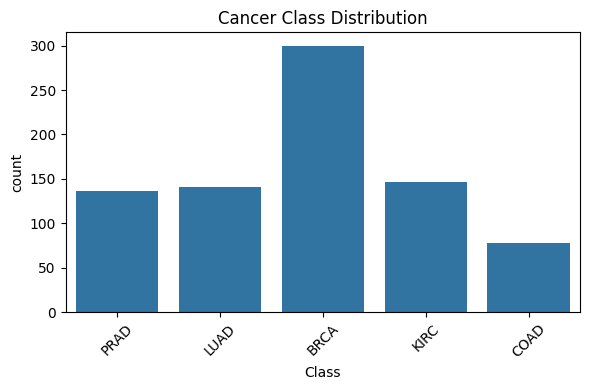

In [29]:
# Cancer Class Distribution (Bar Chart)
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Cancer Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

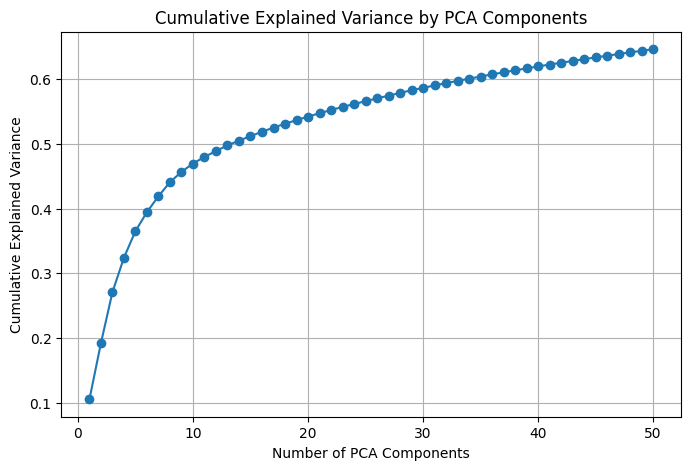

In [30]:
#PCA: Cumulative Explained Variance Plot
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(pca.explained_variance_ratio_)+1),
    np.cumsum(pca.explained_variance_ratio_),
    marker='o'
)
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

/tmp/ipython-input-2930347784.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df_numeric = results_df.set_index('Model')[metrics].replace('-', np.nan)


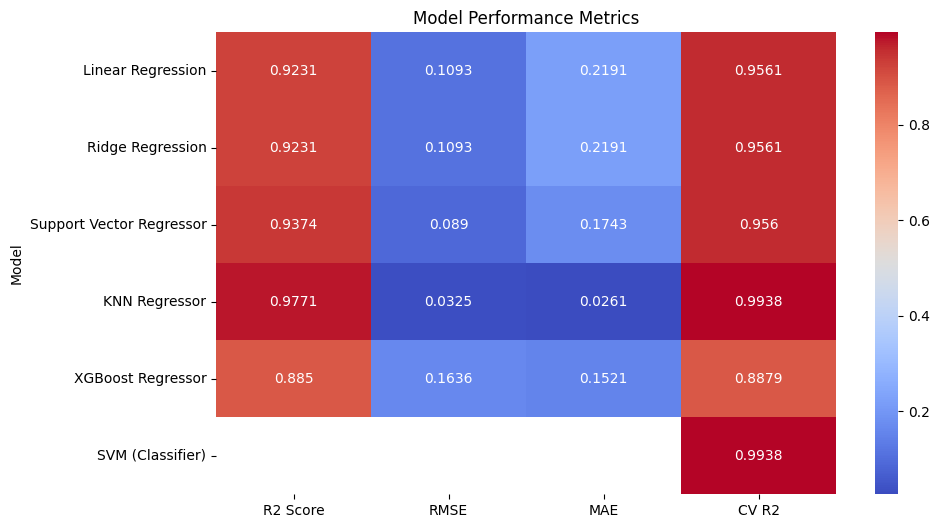

In [35]:
#Model Performance Heatmap
plt.figure(figsize=(10, 6))
metrics = ['R2 Score', 'RMSE', 'MAE', 'CV R2']
results_df_numeric = results_df.set_index('Model')[metrics].replace('-', np.nan)
sns.heatmap(results_df_numeric, annot=True, cmap='coolwarm', fmt='.4g')
plt.title('Model Performance Metrics')
plt.show()

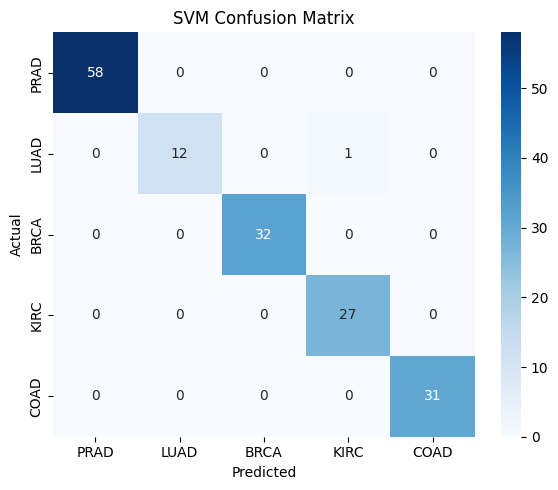

In [34]:
#SVM Confusion Matrix (Already Saved, But for Display)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()